Giuseppe Galilei s295620

# Problem 2

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.size'] = '18'

In [2]:
#transition rate matrix
lambda_matrix=[[0,2/5,1/5,0,0],
   [0,0,3/4,1/4,0],
   [1/2,0,0,1/2,0],
   [0,0,1/3,0,2/3],
   [0,1/3,0,1/3,0]]

In [3]:
G=nx.DiGraph()
G.add_nodes_from(['o','a','b','c','d'])
G.add_edges_from([('o','a'),('o','b'),('a','b'),('a','c'),('b','o'),('b','c'),('c','b'),('c','d'),('d','a'),('d','c')])

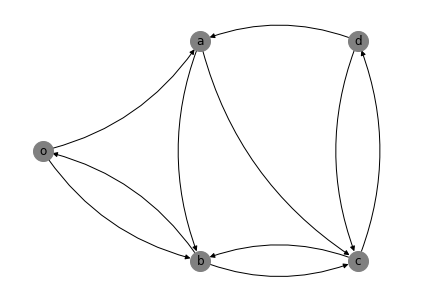

In [4]:
pos={'o': (0,1.5),'a': (1,3),'b': (1,0),'c': (2,0),'d': (2,3)}
nodeToInt={'o':0,'a':1,'b':2,'c':3,'d':4}
intToNode = {v:k for k,v in nodeToInt.items()}
nx.draw(G, pos, connectionstyle="arc3, rad=0.2", with_labels=True,node_color='grey',node_size=400)
plt.savefig("hw2_2.eps", format='eps')

## A - Particle perspective

### A.1

In [5]:
def returnTime_NparticlePersp(lambda_matrix, pos_start, pos_dest_array, nodeToInt_dict, n_particles):
    w = np.sum(lambda_matrix, axis=1)
    w_star = np.max(w)
    Q = lambda_matrix/w_star 
    Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))
    Q_cum = np.cumsum(Q, axis=1)
    
    t_next = -np.log(np.random.rand())/(w_star*n_particles)
    
    pos_start=nodeToInt_dict[pos_start]
    pos_dest_array=list(map(lambda x: nodeToInt_dict[x], pos_dest_array))

    #initialize position for all particles to pos_start
    pos_pre=np.full(n_particles, pos_start)
    #vector of flags to identify if a particle has left her start position
    moved=np.zeros(n_particles)
    #initialize time to reach destination, for each particle, to zero
    time_to_dest=np.zeros(n_particles)
    
    #count of "returned" particles
    c=0

    while True:
        #choose particle(even if particle alread arrived)
        particle= np.random.randint(n_particles)
        
        #if a particle still has to be moved around the network
        if pos_pre[particle] not in pos_dest_array or moved[particle]!=True:
            pos_post = np.argwhere(Q_cum[pos_pre[particle]] > np.random.rand())[0][0]
        
            if pos_post != pos_start:
                moved[particle]=1
                
            #if a particle has reached the destination (has returned)
            if pos_post in pos_dest_array and moved[particle]==True :
                time_to_dest[particle] += t_next
                #increase the count of returned particles
                c+=1
                
            pos_pre[particle]=pos_post

        for i in range(0,n_particles):
            #particles still to be moved around the network
            if pos_pre[i] not in pos_dest_array or moved[i]!=True:
                #add time to all such particles
                time_to_dest[i] += t_next
        
        #if alla particles have returned
        if c==n_particles:
            return time_to_dest
        
        t_next = -np.log(np.random.rand())/(w_star*n_particles)

In [6]:
return_times=[]
for i in range(1000):
    return_times.append(np.average(returnTime_NparticlePersp(lambda_matrix, 'a', ['a'], nodeToInt, 100)))

In [7]:
avg_return_time=np.average(return_times)
print("The average return time is:", avg_return_time)

The average return time is: 6.780003773603592


## B - Node perspective 

In [8]:
def particlePlacement_nodePersp(lambda_matrix, pos_start, nodeToInt_dict, n_particles, time_units_avail, n_nodes):
    w = np.sum(lambda_matrix, axis=1)
    w_star = np.max(w)
    Q = lambda_matrix/w_star 
    Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))
    Q_cum = np.cumsum(Q, axis=1)
    
    pos_start=nodeToInt_dict[pos_start]
        
    #initialize position of particles on starting node
    particleCount_node=np.zeros(n_nodes)
    particleCount_node[pos_start]=n_particles
    
    #initialize history array to contain snapshots of the count of particles on each node
    particleCount_node_History=np.zeros((1,n_nodes))
    particleCount_node_History[0][pos_start]=n_particles
    
    #counter of exploited total time
    t_tot=0
    #array of timestamps to which history snapshots are referred
    time_units=[0]
    
    while t_tot<time_units_avail:
        node_pre=np.random.choice(n_nodes,p=particleCount_node/n_particles)
        node_post = np.argwhere(Q_cum[node_pre] > np.random.rand())[0][0]
        
        particleCount_node[node_pre]-=1
        particleCount_node[node_post]+=1
        
        t_tot += -np.log(np.random.rand())/(w_star*n_particles)
        time_units.append(t_tot)
      
        particleCount_node_History=np.vstack([particleCount_node_History, particleCount_node])
    
            
    return particleCount_node_History, time_units

### B.1

In [9]:
history, time=particlePlacement_nodePersp(lambda_matrix, 'o', nodeToInt, 100, 60, len(G.nodes))

last_rows=np.array(history[-1])

#compute the ending particle placement for several simulations
for i in range (100):
    history, time=particlePlacement_nodePersp(lambda_matrix, 'o', nodeToInt, 100, 60, len(G.nodes))

    last_rows= np.vstack((last_rows,history[-1]))

In [10]:
average_placement=np.mean(last_rows, axis=0)
print("The average particle placement over 100 simulations is (for nodes [o,a,b,c,d]):\n",average_placement)

The average particle placement over 100 simulations is (for nodes [o,a,b,c,d]):
 [18.33663366 15.43564356 22.33663366 21.10891089 22.78217822]


### B.2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Final particle placement in the plotted simulation: [16. 17. 25. 17. 25.]


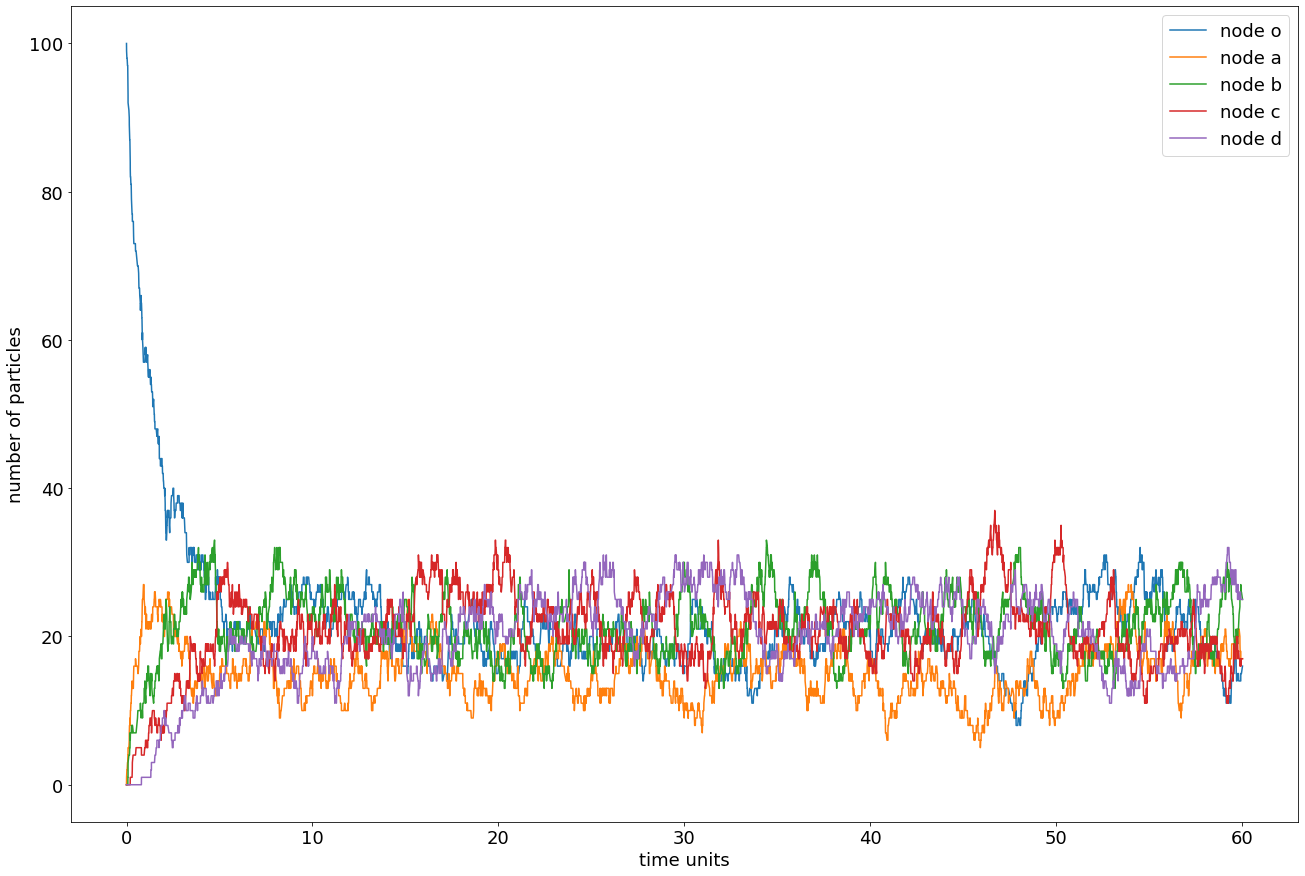

In [11]:
fig = plt.figure(1, figsize=(22,15))
ax = plt.subplot(111)

for node in range(G.number_of_nodes()):
    trajectory = history[:,node]
    ax.plot(time,trajectory, label="node "+intToNode[node])
    plt.xlabel("time units")
    plt.ylabel("number of particles")
    
ax.legend()

plt.savefig("hw2_2_b2.eps", format='eps')
print("Final particle placement in the plotted simulation:", history[-1])

### B.3

In [12]:
w = np.sum(lambda_matrix, axis=1)
L=np.diag(w)-lambda_matrix
values,vectors = np.linalg.eig(L.T)
index = np.argwhere(np.isclose(values.real, 0))
pi_bar = vectors[:,index].real
pi_bar = (pi_bar/np.sum(pi_bar)).reshape(-1)

In [13]:
print("The stationary probability vector pi_bar:", pi_bar)

The stationary probability vector pi_bar: [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


In [14]:
particleCount_node_History[0][1]

NameError: name 'particleCount_node_History' is not defined

In [16]:
print("Difference in absolut value between average particle placements at the end of the simulation \
and the stationary probability vector pi_bar:", np.abs(average_placement-pi_bar*100))

Difference in absolut value between average particle placements at the end of the simulation and the stationary probability vector pi_bar: [0.18188486 0.62082875 0.11441144 1.11331133 0.559956  ]
